In [40]:
import dandelion as ddl
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu
import mudata as md
from mudata import MuData
import numpy as np
import warnings
import os

import scirpy as ir
from cycler import cycler

from matplotlib import cm as mpl_cm
from matplotlib import pyplot as plt

from palmotif import compute_motif, svg_logo
import seaborn as sb
warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore")
ddl.logging.print_header()

# Desactivar todos los warnings
warnings.filterwarnings("ignore")

# Opcional: Desactivar warnings específicos (ejemplo: FutureWarnings de anndata)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)

# Si usas tqdm y deseas evitar sus warnings
from tqdm import TqdmWarning
warnings.simplefilter(action="ignore", category=TqdmWarning)

dandelion==0.5.0 pandas==2.2.3 numpy==2.0.2 matplotlib==3.9.3 networkx==3.4.2 scipy==1.14.1


In [41]:
# Definir rutas de los archivos
mudata_file = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/mudata_TCR_GEX_intersected.h5mu"

# 📌 Definir rutas de los archivos
# output from 03_Annotation_signatures_SH-TCR_10pts.ipynb :
firmas_tcr_file = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/04_anotacion_celltypist_ProjecTIL_firmas/Analisis_firmas_TCR_AUC_10_pts.tsv"
#output from the joining from celltypist and ATLAS_TIL score and phenotype per cell and is_TCR:
firmas_atlas_til_file = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/04_anotacion_celltypist_ProjecTIL_firmas/Anotacion_GEX_TCR.tsv"
# output from 05_Study_TCRdist3.ipynb :
tcr_probabilidad_file = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/07_analisis_repertorio/TCR_probabilidad_generacion_10_pts.tsv"


In [42]:
mdata = mu.read(mudata_file)

In [43]:
mdata

MuData object with n_obs × n_vars = 49043 × 23209
  2 modalities
    gex:	49043 x 23209
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
      layers:	'counts_soupx_crude', 'original_counts'
    airr:	49043 x 0
      obs:	'sample', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size', 'clonal_expansion', 'clone_id_freq'
      uns:	'chain_indices', 'clone_id', 'ir_dist_nt_identity'
      obsm:	'airr', 'chain_indices'

In [44]:
# -----------------------------------------------------------------------------
# 1. LEER ARCHIVOS DE FIRMA
# -----------------------------------------------------------------------------
df_firmas_tcr = pd.read_csv(firmas_tcr_file, sep="\t")
df_firmas_atlas_til = pd.read_csv(firmas_atlas_til_file, sep="\t")

# -----------------------------------------------------------------------------
# 2. RENOMBRAR COLUMNA "Unnamed: 0" A "cell_id" SI FUERA NECESARIO
# -----------------------------------------------------------------------------
if "Unnamed: 0" in df_firmas_tcr.columns:
    df_firmas_tcr.rename(columns={"Unnamed: 0": "cell_id"}, inplace=True)

# -----------------------------------------------------------------------------
# 3. PONER "cell_id" COMO ÍNDICE EN LAS FIRMAS TCR Y LIMPIAR ESPACIOS
# -----------------------------------------------------------------------------
df_firmas_tcr.set_index("cell_id", inplace=True)
df_firmas_tcr.index = df_firmas_tcr.index.str.strip()  # <--- Limpia los espacios

# Para atlas, primero renombra "barcode" a "cell_id" y luego set_index
df_firmas_atlas_til_selected = df_firmas_atlas_til[
    ['barcode', 'functional.cluster', 'functional.cluster.conf', 
     'majority_voting_low', 'conf_score_low']
].copy()
df_firmas_atlas_til_selected.rename(columns={'barcode': 'cell_id'}, inplace=True)
df_firmas_atlas_til_selected.set_index("cell_id", inplace=True)
df_firmas_atlas_til_selected.index = df_firmas_atlas_til_selected.index.str.strip()

# -----------------------------------------------------------------------------
# 4. ASEGURAR QUE "cell_id" EXISTE EN mdata["airr"].obs COMO COLUMNA
#    (y no como índice)
# -----------------------------------------------------------------------------
if "cell_id" not in mdata["airr"].obs.columns:
    mdata["airr"].obs.reset_index(inplace=True)
    # Renombrar la columna del index (antes 'index') a "cell_id"
    mdata["airr"].obs.rename(columns={mdata["airr"].obs.index.name: 'cell_id'}, inplace=True)

# Convertir a string si fuera necesario
mdata["airr"].obs["cell_id"] = mdata["airr"].obs["cell_id"].astype(str)

# -----------------------------------------------------------------------------
# 5. FUSIONAR. AHORA USAMOS "left_on" Y "right_index"
# -----------------------------------------------------------------------------
# Unimos primero con df_firmas_tcr
mdata["airr"].obs = mdata["airr"].obs.merge(
    df_firmas_tcr,
    left_on="cell_id",
    right_index=True,
    how="left"
)

# Unimos después con df_firmas_atlas_til_selected
mdata["airr"].obs = mdata["airr"].obs.merge(
    df_firmas_atlas_til_selected,
    left_on="cell_id",
    right_index=True,
    how="left"
)

# -----------------------------------------------------------------------------
# 6. VERIFICAR RESULTADO
# -----------------------------------------------------------------------------
print(mdata["airr"].obs.head(10))
print(f"✅ Dimensiones finales: {mdata['airr'].obs.shape}")


                   cell_id sample receptor_type receptor_subtype  \
0  AAACCTGAGAAGAAGC-1_PT14  PT_14           TCR          TRA+TRB   
1  AAACCTGAGGACAGAA-1_PT14  PT_14           TCR          TRA+TRB   
2  AAACCTGAGTGGAGTC-1_PT14  PT_14           TCR          TRA+TRB   
3  AAACCTGAGTGTCTCA-1_PT14  PT_14           TCR          TRA+TRB   
4  AAACCTGCAAACTGTC-1_PT14  PT_14           TCR          TRA+TRB   
5  AAACCTGCACAGCCCA-1_PT14  PT_14           TCR          TRA+TRB   
6  AAACCTGCAGACGCCT-1_PT14  PT_14           TCR          TRA+TRB   
7  AAACCTGCATCACGAT-1_PT14  PT_14           TCR          TRA+TRB   
8  AAACCTGGTAAGGGAA-1_PT14  PT_14           TCR          TRA+TRB   
9  AAACCTGGTCATATCG-1_PT14  PT_14           TCR          TRA+TRB   

  chain_pairing clone_id  clone_id_size clonal_expansion  clone_id_freq  \
0   single pair        0             32             ≤ 50       0.000424   
1   single pair        1              1              ≤ 1       0.000013   
2   single pair        2  

In [45]:
mdata["airr"].obs

,cell_id,sample,receptor_type,receptor_subtype,chain_pairing,clone_id,clone_id_size,clonal_expansion,clone_id_freq,FirmaCimaPlus_FINAL,FirmaCima_FINAL,Firma_Oliveira_FINAL,Lowery_Patente-2_FINAL(CD8),Lowery_Patente_FINAL(CD8),Petremand_FINAL,Lowery_ALL_FINAL,functional.cluster,functional.cluster.conf,majority_voting_low,conf_score_low
0,AAACCTGAGAAGAAGC-1_PT14,PT_14,TCR,TRA+TRB,single pair,0,32,≤ 50,0.000424,-0.752329,-0.758073,-0.287170,-0.688035,-0.630233,-1.188962,0.828910,CD8.CM,1.000000,Tem/Trm cytotoxic T cells,0.340514
1,AAACCTGAGGACAGAA-1_PT14,PT_14,TCR,TRA+TRB,single pair,1,1,≤ 1,0.000013,0.625701,0.118228,-0.014908,0.678248,0.682879,0.346079,0.079219,CD4.Tfh,1.000000,Regulatory T cells,0.760998
2,AAACCTGAGTGGAGTC-1_PT14,PT_14,TCR,TRA+TRB,single pair,2,1,≤ 1,0.000013,2.025910,2.215051,1.653671,1.889315,1.776027,1.278230,1.133224,CD4.Treg,1.000000,Regulatory T cells,1.000000
3,AAACCTGAGTGTCTCA-1_PT14,PT_14,TCR,TRA+TRB,single pair,3,1,≤ 1,0.000013,0.921286,0.943197,-0.206695,-0.580143,-0.594523,-0.106789,-1.227325,CD4.Tfh,0.512710,Tem/Effector helper T cells,0.662542
4,AAACCTGCAAACTGTC-1_PT14,PT_14,TCR,TRA+TRB,extra VJ,4,1,≤ 1,0.000013,-0.629738,-0.644773,-0.267204,-0.800694,-0.806296,-0.889228,-0.676812,CD4.NaiveLike,0.884838,Type 1 helper T cells,0.287589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49038,TTTGTCAGTGTGGCTC-1_PT50,PT_50,TCR,TRA+TRB,single pair,19839,70,≤ 100,0.000237,0.741716,0.944403,1.660267,0.079831,0.088690,1.873980,1.026855,CD4.Treg,1.000000,Regulatory T cells,0.999999
49039,TTTGTCATCGTGGGAA-1_PT50,PT_50,TCR,TRA+TRB,single pair,19835,241,≤ 500,0.000817,-0.220452,-0.178621,-0.524739,0.372458,0.383933,-0.014812,0.637481,NaN,NaN,Tem/Temra cytotoxic T cells,0.927800
49040,TTTGTCATCTGCTGCT-1_PT50,PT_50,TCR,TRA+TRB,single pair,20128,16,≤ 50,0.000054,0.737083,0.898829,1.680996,1.090358,1.108068,1.224015,0.451511,CD4.Treg,1.000000,Regulatory T cells,1.000000
49041,TTTGTCATCTTGTTTG-1_PT50,PT_50,TCR,TRA+TRB,single pair,19804,421,≤ 500,0.001427,-0.660960,-0.739454,0.658935,0.286536,0.280150,0.107406,0.384942,CD8.TEX,0.407424,Tem/Trm cytotoxic T cells,0.996792


In [46]:
# 📌 Renombrar directamente las columnas en mdata["airr"].obs
mdata["airr"].obs.rename(columns={
    'functional.cluster': 'ATLAS_TIL',
    'functional.cluster.conf': 'ATLAS_TIL_score',
    'majority_voting_low': 'Celltypist',
    'conf_score_low': 'Celltypist_score'
}, inplace=True)

Tenemos que unir primero todas las caracteristicas tanto: 

In [47]:
# -----------------------------------------------------------------------------
# 7. AÑADIR COLUMNAS DE PROBABILIDAD TCR
# -----------------------------------------------------------------------------

# 📌 Leer el archivo de probabilidad si aún no está cargado
tcr_probabilidad = pd.read_csv(tcr_probabilidad_file, sep="\t")

# 📌 Asegurar que `cell_id` está como columna (no en el índice)
if "Unnamed: 0" in tcr_probabilidad.columns:
    tcr_probabilidad.rename(columns={"Unnamed: 0": "cell_id"}, inplace=True)

if tcr_probabilidad.index.name == "cell_id":
    tcr_probabilidad.reset_index(inplace=True)

# 📌 Seleccionar las columnas necesarias
tcr_probabilidad_selected = tcr_probabilidad[
    ['cell_id', 'pgen_cdr3_b_aa_nlog10_z', 'pgen_cdr3_a_aa_nlog10_z']
].copy()

# Convertir `cell_id` a string por seguridad
tcr_probabilidad_selected["cell_id"] = tcr_probabilidad_selected["cell_id"].astype(str)

# 📌 Unir con mdata["airr"].obs
mdata["airr"].obs["cell_id"] = mdata["airr"].obs["cell_id"].astype(str)
mdata["airr"].obs = mdata["airr"].obs.merge(
    tcr_probabilidad_selected,
    on="cell_id",
    how="left"
)

# 📌 Verificar resultado
print(mdata["airr"].obs.head(10))
print(f"✅ Dimensiones finales: {mdata['airr'].obs.shape}")

                   cell_id sample receptor_type receptor_subtype  \
0  AAACCTGAGAAGAAGC-1_PT14  PT_14           TCR          TRA+TRB   
1  AAACCTGAGGACAGAA-1_PT14  PT_14           TCR          TRA+TRB   
2  AAACCTGAGTGGAGTC-1_PT14  PT_14           TCR          TRA+TRB   
3  AAACCTGAGTGTCTCA-1_PT14  PT_14           TCR          TRA+TRB   
4  AAACCTGCAAACTGTC-1_PT14  PT_14           TCR          TRA+TRB   
5  AAACCTGCACAGCCCA-1_PT14  PT_14           TCR          TRA+TRB   
6  AAACCTGCAGACGCCT-1_PT14  PT_14           TCR          TRA+TRB   
7  AAACCTGCATCACGAT-1_PT14  PT_14           TCR          TRA+TRB   
8  AAACCTGGTAAGGGAA-1_PT14  PT_14           TCR          TRA+TRB   
9  AAACCTGGTCATATCG-1_PT14  PT_14           TCR          TRA+TRB   

  chain_pairing clone_id  clone_id_size clonal_expansion  clone_id_freq  \
0   single pair        0             32             ≤ 50       0.000424   
1   single pair        1              1              ≤ 1       0.000013   
2   single pair        2  

In [48]:
mdata["airr"].obs

,cell_id,sample,receptor_type,receptor_subtype,chain_pairing,clone_id,clone_id_size,clonal_expansion,clone_id_freq,FirmaCimaPlus_FINAL,...,Lowery_Patente-2_FINAL(CD8),Lowery_Patente_FINAL(CD8),Petremand_FINAL,Lowery_ALL_FINAL,ATLAS_TIL,ATLAS_TIL_score,Celltypist,Celltypist_score,pgen_cdr3_b_aa_nlog10_z,pgen_cdr3_a_aa_nlog10_z
0,AAACCTGAGAAGAAGC-1_PT14,PT_14,TCR,TRA+TRB,single pair,0,32,≤ 50,0.000424,-0.752329,...,-0.688035,-0.630233,-1.188962,0.828910,CD8.CM,1.000000,Tem/Trm cytotoxic T cells,0.340514,0.205800,0.221228
1,AAACCTGAGGACAGAA-1_PT14,PT_14,TCR,TRA+TRB,single pair,1,1,≤ 1,0.000013,0.625701,...,0.678248,0.682879,0.346079,0.079219,CD4.Tfh,1.000000,Regulatory T cells,0.760998,-0.250866,4.527288
2,AAACCTGAGTGGAGTC-1_PT14,PT_14,TCR,TRA+TRB,single pair,2,1,≤ 1,0.000013,2.025910,...,1.889315,1.776027,1.278230,1.133224,CD4.Treg,1.000000,Regulatory T cells,1.000000,-0.361990,-0.444098
3,AAACCTGAGTGTCTCA-1_PT14,PT_14,TCR,TRA+TRB,single pair,3,1,≤ 1,0.000013,0.921286,...,-0.580143,-0.594523,-0.106789,-1.227325,CD4.Tfh,0.512710,Tem/Effector helper T cells,0.662542,1.989705,0.956967
4,AAACCTGCAAACTGTC-1_PT14,PT_14,TCR,TRA+TRB,extra VJ,4,1,≤ 1,0.000013,-0.629738,...,-0.800694,-0.806296,-0.889228,-0.676812,CD4.NaiveLike,0.884838,Type 1 helper T cells,0.287589,-0.208715,-0.269146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49038,TTTGTCAGTGTGGCTC-1_PT50,PT_50,TCR,TRA+TRB,single pair,19839,70,≤ 100,0.000237,0.741716,...,0.079831,0.088690,1.873980,1.026855,CD4.Treg,1.000000,Regulatory T cells,0.999999,-0.830088,-0.061389
49039,TTTGTCATCGTGGGAA-1_PT50,PT_50,TCR,TRA+TRB,single pair,19835,241,≤ 500,0.000817,-0.220452,...,0.372458,0.383933,-0.014812,0.637481,NaN,NaN,Tem/Temra cytotoxic T cells,0.927800,-0.015354,0.036121
49040,TTTGTCATCTGCTGCT-1_PT50,PT_50,TCR,TRA+TRB,single pair,20128,16,≤ 50,0.000054,0.737083,...,1.090358,1.108068,1.224015,0.451511,CD4.Treg,1.000000,Regulatory T cells,1.000000,0.872529,0.004394
49041,TTTGTCATCTTGTTTG-1_PT50,PT_50,TCR,TRA+TRB,single pair,19804,421,≤ 500,0.001427,-0.660960,...,0.286536,0.280150,0.107406,0.384942,CD8.TEX,0.407424,Tem/Trm cytotoxic T cells,0.996792,0.732333,0.027040


Analisis:

In [49]:
# 📌 Contar el número de valores NaN en 'functional.cluster'
num_na_functional_cluster = mdata["airr"].obs["ATLAS_TIL"].isna().sum()

# 📌 Calcular el número total de filas en `mdata["airr"].obs`
total_rows = mdata["airr"].obs.shape[0]

# 📌 Calcular el porcentaje de valores NaN en 'functional.cluster'
percent_na_functional_cluster = (num_na_functional_cluster / total_rows) * 100

# 📌 Mostrar los resultados
print(f"🔍 Número de valores NaN en 'ATLAS_TIL': {num_na_functional_cluster}")
print(f"📉 Porcentaje de NaN en 'ATLAS_TILr': {percent_na_functional_cluster:.2f}%")

🔍 Número de valores NaN en 'ATLAS_TIL': 4157
📉 Porcentaje de NaN en 'ATLAS_TILr': 8.48%


In [50]:
print(mdata.mod['gex'].obs.index.dtype)
print(mdata.mod['airr'].obs.index.dtype)

object
int64


In [51]:
# Establecer 'cell_id' como índice
mdata.mod['airr'].obs.set_index('cell_id', inplace=True)

# Verificar el índice actualizado
print(mdata.mod['airr'].obs.index[:5])



Index(['AAACCTGAGAAGAAGC-1_PT14', 'AAACCTGAGGACAGAA-1_PT14',
       'AAACCTGAGTGGAGTC-1_PT14', 'AAACCTGAGTGTCTCA-1_PT14',
       'AAACCTGCAAACTGTC-1_PT14'],
      dtype='object', name='cell_id')


In [52]:
# Verificar diferencias entre los índices de 'gex' y 'airr'
indices_diferentes = mdata.mod['gex'].obs.index.symmetric_difference(mdata.mod['airr'].obs.index)
print(f"Número de índices diferentes tras la corrección: {len(indices_diferentes)}")

Número de índices diferentes tras la corrección: 0


In [53]:
# Guarda el objeto 'mdata' (tipo MuData) en un archivo .h5mu
output_path = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/04_datos_concatenados/mdata_TCR_GEX_firmas.h5mu"
mdata.write_h5mu(output_path)

In [54]:
mdata = mu.read("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/04_datos_concatenados/mdata_TCR_GEX_firmas.h5mu")

In [55]:
mdata

MuData object with n_obs × n_vars = 49043 × 23209
  2 modalities
    gex:	49043 x 23209
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
      layers:	'counts_soupx_crude', 'original_counts'
    airr:	49043 x 0
      obs:	'sample', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size', 'clonal_expansion', 'clone_id_freq', 'FirmaCimaPlus_FINAL ', 'FirmaCima_FINAL ', 'Firma_Oliveira_FINAL ', 'Lowery_Patente-2_FINAL(CD8) ', 'Lowery_Patente_FINAL(CD8) ', 'Petremand_FINAL ', 'Lowery_ALL_FINAL', 'ATLAS_TIL', 'ATLAS_TIL_score', 'Celltypist', 'Celltypist_score', 'pgen_cdr3_b_aa_nlog10_z', 'pgen_cdr3_a_aa_nlog10_z'
      uns:	'chain_indices', 'clone_id', 'ir_dist_nt_identity'
      obsm:	'airr', 'chain_indices'

In [56]:
# -----------------------------------------------------------------------------
# 2. Definir las columnas a copiar y las celdas comunes
# -----------------------------------------------------------------------------
cols_to_copy = ["ATLAS_TIL", "ATLAS_TIL_score"]

common_cells = mdata["airr"].obs_names.intersection(mdata["gex"].obs_names)
print(f"Total celdas en 'airr': {mdata['airr'].n_obs}")
print(f"Total celdas en 'gex':  {mdata['gex'].n_obs}")
print(f"Células comunes:        {len(common_cells)}")

# -----------------------------------------------------------------------------
# 3. Copiar las columnas a la modalidad "gex" para esas celdas comunes
# -----------------------------------------------------------------------------
for col in cols_to_copy:
    if col in mdata["airr"].obs.columns:
        mdata["gex"].obs.loc[common_cells, col] = mdata["airr"].obs.loc[common_cells, col]
    else:
        print(f"⚠️ La columna '{col}' no está en mdata['airr'].obs")

# -----------------------------------------------------------------------------
# 4. Crear un AnnData con solo las celdas comunes de 'gex'
# -----------------------------------------------------------------------------
adata = mdata["gex"][list(common_cells), :].copy()

print("Dimensiones de adata final:", adata.shape)
print("Columnas en adata.obs:", adata.obs.columns.tolist())

Total celdas en 'airr': 49043
Total celdas en 'gex':  49043
Células comunes:        49043
Dimensiones de adata final: (49043, 23209)
Columnas en adata.obs: ['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'ATLAS_TIL', 'ATLAS_TIL_score']


In [57]:
output_file = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/04_datos_concatenados/adata_conTCR_GEX_firmas.h5ad"
adata.write_h5ad(output_file)

### Integration with Harmony 

In [58]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [59]:
#con el environment scvi-tune
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import gzip
from matplotlib.pyplot import rc_context
import anndata as ad  # Importa anndata
import numpy as np
import scanpy.external as sce
import harmonypy as hm
from scipy.stats import pearsonr
import mudata as md
from mudata import MuData
import muon as mu
sc.set_figure_params(dpi=100)

In [60]:
mdata = mu.read("/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/04_datos_concatenados/mdata_TCR_GEX_firmas.h5mu")

In [61]:
adata_gex = mdata.mod['gex'].copy()
adata_gex.X = adata_gex.layers['counts_soupx_crude'].copy()

In [62]:
# Normalización total y log-transformación
sc.pp.normalize_total(adata_gex, target_sum=1e4)
sc.pp.log1p(adata_gex)

In [63]:
# Detección de los 3000 genes más variables por muestra (batch_key='Sample')
sc.pp.highly_variable_genes(adata_gex, n_top_genes=4000, batch_key='Sample', subset=False)

In [64]:
# Crear una copia temporal con solo los HVG para cálculos posteriores
hvg_data_harmony = adata_gex[:, adata_gex.var['highly_variable']].copy()

In [65]:
# Verificación del número de genes altamente variables
num_hvg = hvg_data_harmony.var['highly_variable'].sum()
print(f"Número de genes altamente variables: {num_hvg}")

Número de genes altamente variables: 4000


In [66]:
# Ajuste por covariables técnicas
sc.pp.regress_out(hvg_data_harmony, keys=['pct_counts_mt', 'pct_counts_ribo','total_counts'])

In [67]:
# Escalar los datos antes de PCA
sc.pp.scale(hvg_data_harmony, max_value=10)

In [68]:
# Cálculo de la PCA usando solo genes altamente variables
sc.tl.pca(hvg_data_harmony, svd_solver='arpack')

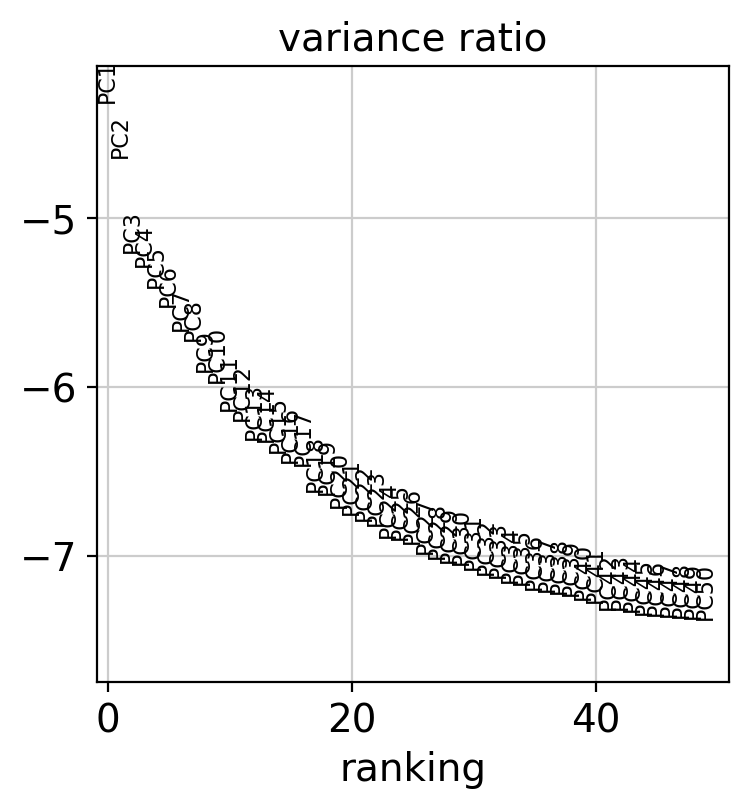

In [69]:
# Visualizar el codo para verificar el número de PCs significativas (opcional)
sc.pl.pca_variance_ratio(hvg_data_harmony, log=True, n_pcs=50)

In [70]:
# Integración con Harmony
sce.pp.harmony_integrate(hvg_data_harmony, key='Sample')

2025-02-17 14:17:27,264 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-02-17 14:17:37,353 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-17 14:17:37,545 - harmonypy - INFO - Iteration 1 of 10
2025-02-17 14:17:47,770 - harmonypy - INFO - Iteration 2 of 10
2025-02-17 14:18:02,062 - harmonypy - INFO - Converged after 2 iterations


In [71]:
sc.pp.neighbors(
    hvg_data_harmony,
    use_rep='X_pca_harmony',
    n_neighbors=30,       # Aumenta la conectividad entre células distantes
    n_pcs=20,              # Mantiene las PCs relevantes
    metric='euclidean'     # Para una mejor representación de las distancias
)

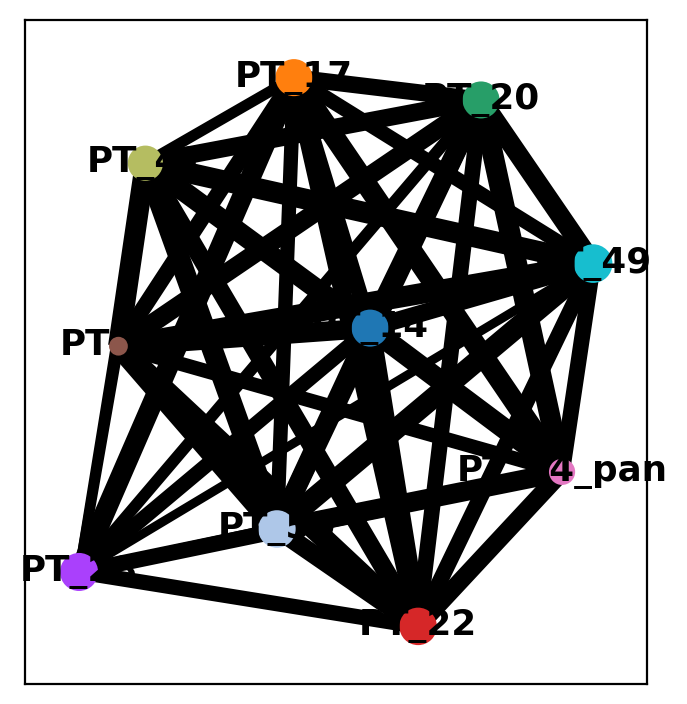

In [72]:
sc.tl.paga(hvg_data_harmony, groups="Sample")  # O el nombre de tus grupos
sc.pl.paga(hvg_data_harmony)  # Esto generará `adata.uns['paga']['pos']`

sc.tl.umap(
    hvg_data_harmony,
    min_dist=0.05,      # Más separación entre clusters
    spread=2.5,         # Mayor dispersión
    n_components=2,     # Visualización en 2D
    init_pos='paga',  # Alternativa estable basada en el grafo de vecinos
    random_state=30     # Reproducibilidad
)

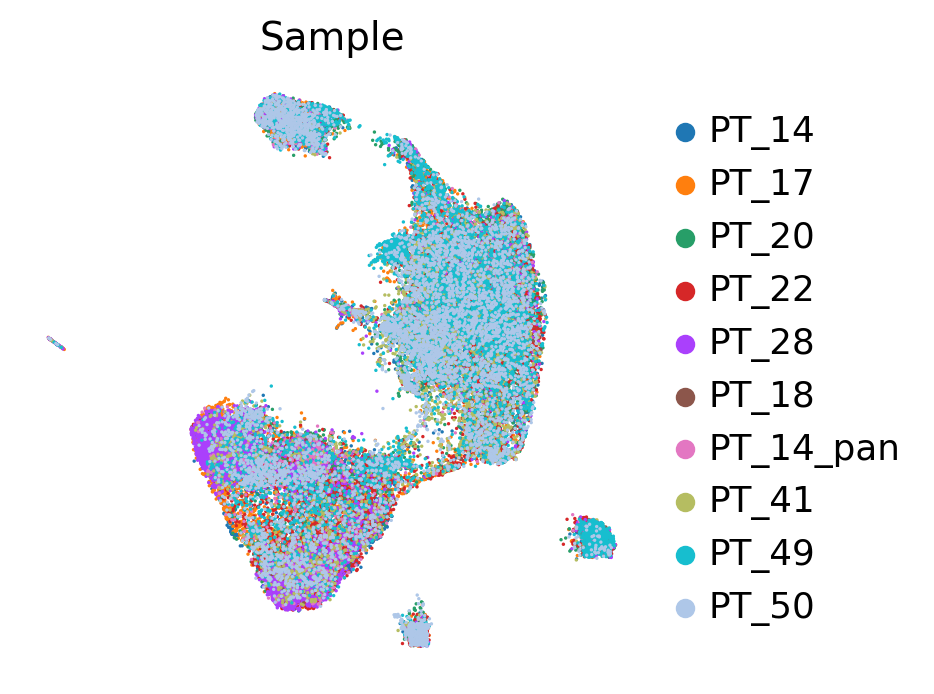

In [73]:
sc.pl.umap(
    hvg_data_harmony,
    color='Sample',         # Colorear por muestra
    size=6,                 # Tamaño de puntos equilibrado
    frameon=False          # Sin borde para un aspecto más limpios)'
)

In [74]:
# Guardar las coordenadas integradas y UMAP en el objeto principal (23,000 genes)
adata_gex.obsm['X_pca_harmony'] = hvg_data_harmony.obsm['X_pca_harmony']
adata_gex.obsm['X_umap'] = hvg_data_harmony.obsm['X_umap']
adata_gex.uns['neighbors'] = hvg_data_harmony.uns['neighbors']
adata_gex.obsp['connectivities'] = hvg_data_harmony.obsp['connectivities']
adata_gex.obsp['distances'] = hvg_data_harmony.obsp['distances']

# Mantener información sobre los genes altamente variables en el objeto principal
adata_gex.var['highly_variable'] = hvg_data_harmony.var['highly_variable']

In [75]:
# Convertir la columna 'highly_variable' a un tipo consistente (booleano)
adata_gex.var['highly_variable'] = adata_gex.var['highly_variable'].astype(bool)

In [76]:
# Reemplazar la modalidad 'gex' por la versión integrada
mdata.mod['gex'] = adata_gex

In [77]:
mdata

MuData object with n_obs × n_vars = 49043 × 23209
  2 modalities
    gex:	49043 x 23209
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'prediction', 'doublet', 'doublet_filtered', 'Sample', 'n_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'log1p', 'hvg', 'neighbors'
      obsm:	'X_pca_harmony', 'X_umap'
      layers:	'counts_soupx_crude', 'original_counts'
      obsp:	'connectivities', 'distances'
    airr:	49043 x 0
      obs:	'sample', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size', 'clonal_expansion', 'clone_id_freq', 'FirmaCimaPlus_FINAL ', 'FirmaCima_FINAL ', 'Firma_Oliveira_FINAL ', 'Lowery_Patente-2_FINAL(CD8) ', 'Lowery_Patente_FINAL(CD8) ', 'Petremand_FINAL ', 'Lowery_ALL_FINAL', 'ATLAS_TIL', 'ATLAS_TIL_score', 'Celltypist', 'Celltypist_score', 'pgen_cdr3_b_aa_nlog10_z', 'pgen_cdr3_a_aa_nlog10_z'
      uns:	'chain_indices', 'clone_id', 'ir_dist_nt_identity'
      obsm:	'airr', 'chain_indices'

In [78]:
# Guardar el nuevo MuData con la integración de Harmony
output_path = "/data/scratch/LAB/enric/Proyecto_pitagoras/Analisis_pitagoras/Results/05_datos_integrados/mudata_harmony_conTCR.h5mu"
mdata.write_h5mu(output_path)